# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Note que uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.

## Inicializando o Neptune

In [ ]:
! pip install neptune-client==0.9.1

     |████████████████████████████████| 215kB 4.2MB/s 
     |████████████████████████████████| 829kB 45.9MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 163kB 53.3MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 133kB 56.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=a3fd2c1dd352c292eb2d6009b3a4d05d37aeeb209300449b3c68787e7062acd7
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=f2b13b2c5b26db61e948735ecaa224b0579f799a75a2fe08b359139da10e8ced
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
import neptune.new as neptune

# Insira seu api_token para logar os resultados do treino na sua conta do Neptune.
# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token

run = neptune.init(project='eduardocoraca/aula7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJmMzZmYmY3MC01NWJjLTQ1MjItYmVjMC0zNGNjNGZiMDA4YzcifQ==')

https://app.neptune.ai/eduardocoraca/aula7/e/AUL7-21


## Importação das bibliotecas

In [ ]:
!pip install pytorch_lightning
#!pip install pytorch_lightning==1.2.10

     |████████████████████████████████| 808kB 4.3MB/s 
     |████████████████████████████████| 112kB 35.4MB/s 
     |████████████████████████████████| 276kB 39.6MB/s 
     |████████████████████████████████| 645kB 26.4MB/s 
     |████████████████████████████████| 1.3MB 49.5MB/s 
     |████████████████████████████████| 143kB 50.7MB/s 
     |████████████████████████████████| 296kB 34.2MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from collections import OrderedDict
import h5py
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import nn

import torchvision
from torchvision import transforms

import pytorch_lightning
from pytorch_lightning import LightningModule, Trainer

pytorch_lightning.utilities.seed.seed_everything(seed=123)

Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: I

123

In [ ]:
import matplotlib.pyplot as plt

## Dataset e dataloader

In [ ]:
import scipy.ndimage
import sys
import tqdm

Ideia: salvar em memória as imagens já reduzidas para 224x224 -> usar a função scipy.ndimage.zoom para a redução.

In [ ]:
# O download demora.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* .

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/train.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/valid.hdf5...
/ [3/3 files][ 11.3 GiB/ 11.3 GiB] 100% Done  18.5 MiB/s ETA 00:00:00           
Operation completed over 3 objects/11.3 GiB.                                     


### Visualizando o dataset de treinamento

In [ ]:
size_final = (224, 224)

path = './train.hdf5'
h5file = h5py.File(path, 'r')
siz = len(h5file['data'])

img = []
for k in tqdm.tqdm(range(siz//500)):
    a = h5file['data'][k*500:(k+1)*500]
    img.append(scipy.ndimage.zoom(a, (1, size_final[0]/1100, size_final[1]/1100))) # aplica a redução
    del a

img = np.concatenate(img)

100%|██████████| 6/6 [06:28<00:00, 64.72s/it]


Min: 0, Max: 4284


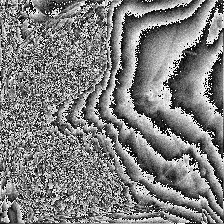

In [ ]:
teste = img[3].copy()
print(f'Min: {teste.min()}, Max: {teste.max()}')

aa = transforms.ToPILImage()(teste.astype(np.uint8))
bb = transforms.ToTensor()(aa)
cc = bb.tile(3, 1, 1)
transforms.ToPILImage()(cc)

Min: 0, Max: 4284


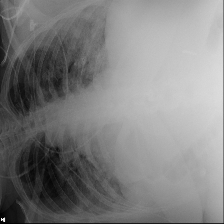

In [ ]:
# Mesma imagem após normalização

teste = img[3].copy()
print(f'Min: {teste.min()}, Max: {teste.max()}')
teste = (teste/np.max(teste))*255
aa = transforms.ToPILImage()(teste.astype(np.uint8))
bb = transforms.ToTensor()(aa)
cc = bb.tile(3, 1, 1)
transforms.ToPILImage()(cc)

Min: 0, Max: 266


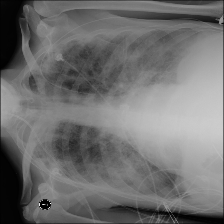

In [ ]:
teste = img[0].copy()
print(f'Min: {teste.min()}, Max: {teste.max()}')

aa = transforms.ToPILImage()(teste.astype(np.uint8))
bb = transforms.ToTensor()(aa)

cc = bb.tile(3, 1, 1)
transforms.ToPILImage()(cc)

Aparentemente, algumas imagens apresentam valores altos de intensidades de pixel, o que acaba gerando problemas ao converter para uint8.

Visualizando o valor máximo dos pixels:

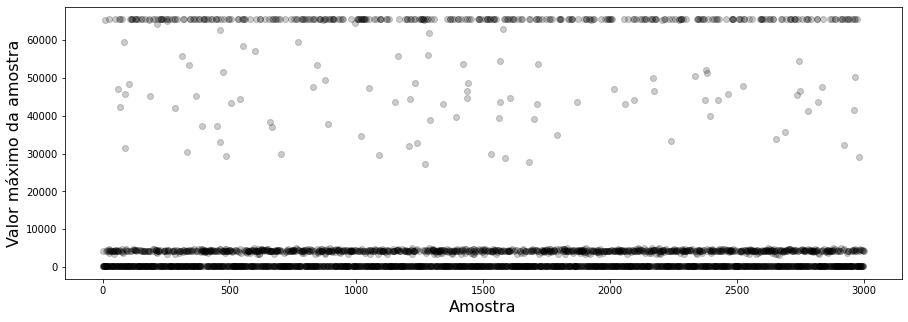

In [ ]:
mx = []
for k in range(len(img)):
  mx.append(img[k].max())

mx = np.array(mx)

plt.figure(figsize=(15,5))
plt.scatter(np.arange(0,len(img)), mx, color='k', alpha=0.2)
plt.xlabel('Amostra', fontsize=16);
plt.ylabel('Valor máximo da amostra', fontsize=16);

### Carregamento, criação dataset e do dataloader

Aqui criamos um dataset sem aumento de dados

In [ ]:
# A ideia é armazenar os datasets com as imagens já reduzidas

size_final = (224, 224)

transform_train = transforms.Compose([
                                      transforms.ToPILImage(),
                                      torchvision.transforms.ToTensor(),
                                      torchvision.transforms.RandomVerticalFlip(),
                                      torchvision.transforms.RandomResizedCrop(size=size_final, scale=(0.7, 1.0)),
                                      transforms.Lambda(lambda x: x.tile(3,1,1)),
                                      torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    #torchvision.transforms.Resize(size=size_final)]) # O resize é aplicado de outra forma

transform_valid = transform_train
transform_test = transform_train

Exemplo de augmentation:

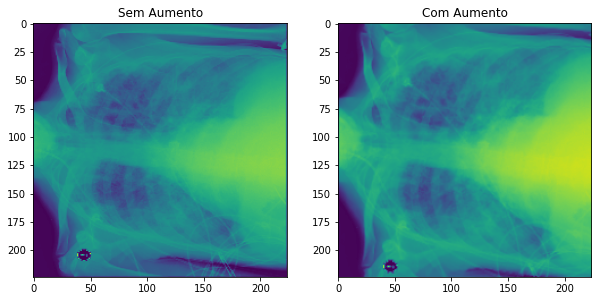

In [ ]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.title('Sem Aumento')
plt.imshow(teste.astype('uint8'));
plt.subplot(1,2,2);
plt.title('Com Aumento')
plt.imshow(transform_train(teste.astype('uint8'))[0]);

In [ ]:
class Hdf5_Dataset(torch.utils.data.Dataset):

    def __init__(self, path, transform, size_final):
        h5file = h5py.File(path, 'r')

        # Hack para deixar mais rapido o carregamento das imagens.
        self.size = len(h5file['data']) # tamanho total do dataset

        # carrega 500 arquivos de cada vez e reduz a dimensão
        img = []
        for k in tqdm.tqdm(range(self.size//500)):
            a = h5file['data'][k*500:(k+1)*500]
            img.append(scipy.ndimage.zoom(a, (1, size_final[0]/1100, size_final[1]/1100))) # aplica a redução
            del a

        self.images = np.concatenate(img) # armazenando todas as imagens reduzidas
        self.labels = h5file['label'][:] # armazenando todas as labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx].astype(np.int32)
        # img = self.images[idx].astype(np.uint8)
        img = ((self.images[idx]/np.max(self.images[idx]))*255).astype(np.uint8)
        img = self.transform(img)
      
        return img, label

In [ ]:
train_dataset = Hdf5_Dataset('./train.hdf5', transform=transform_train, size_final=size_final)

100%|██████████| 6/6 [06:39<00:00, 66.64s/it]


In [ ]:
val_dataset = Hdf5_Dataset('./valid.hdf5', transform=transform_valid, size_final=size_final)

100%|██████████| 2/2 [02:17<00:00, 68.52s/it]


In [ ]:
test_dataset = Hdf5_Dataset('./test.hdf5', transform=transform_test, size_final=size_final)

100%|██████████| 2/2 [02:14<00:00, 67.26s/it]


In [ ]:
# tamanho dos datasets
print(f'Dataset de treino: {len(train_dataset)}')
print(f'Dataset de validação: {len(val_dataset)}')
print(f'Dataset de teste: {len(test_dataset)}')

Dataset de treino: 3000
Dataset de validação: 1000
Dataset de teste: 1000


In [ ]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 60
Número de minibatches de validação: 20
Número de minibatches de teste: 20

Dimensões dos dados de um minibatch: torch.Size([50, 3, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(-2.1179) tensor(2.6384)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


### Visualizando algumas imagens

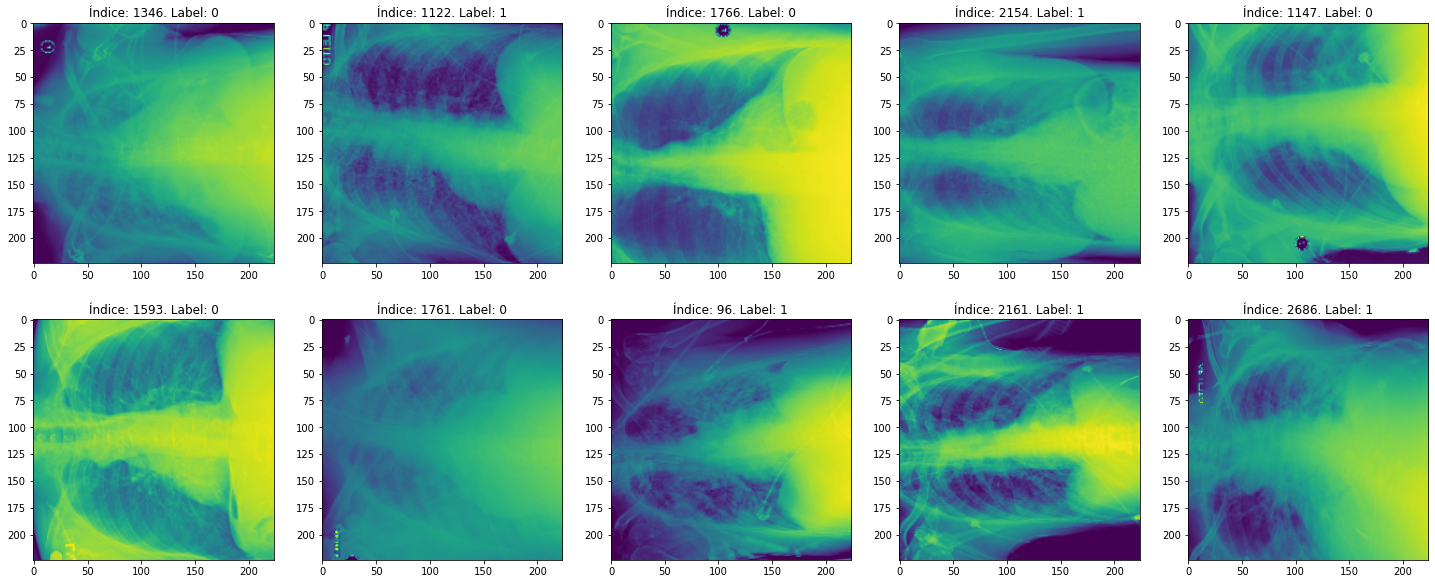

In [ ]:
idx = np.random.randint(low=0, high=len(train_dataset), size=10)

fig = plt.figure(figsize=(25,10))
for i in range(len(idx)):
    ax = fig.add_subplot(2,5,i+1)
    ax.set_title(f'Índice: {idx[i]}. Label: {train_dataset[idx[i]][1]}')
    ax.imshow((train_dataset[idx[i]][0].sum(axis=0)))

## Criando o modelo Resnet18

In [ ]:
import torchvision.models as models
import torchsummary

In [ ]:
class ModeloResnet(torch.nn.Module):
    def __init__(self, congelada):
        super(ModeloResnet, self).__init__()

        self.mod = models.resnet18(pretrained=True)

        # congelando as camadas convolucionais
        if congelada == True:
            for param in self.mod.parameters():
                param.requires_grad = False

        # redefinindo a camada FC
        self.mod.fc = torch.nn.Linear(self.mod.fc.in_features, 2)

    def forward(self, x):
        return self.mod(x)

Instanciando um modelo com as camadas convolucionais congeladas:

In [ ]:
modelo = ModeloResnet(congelada = True)

## Definindo o modelo Lightning

In [ ]:
class LightningClassifier(LightningModule):
    def __init__(self, hparams, modelo):
        super().__init__()

        self.save_hyperparameters(hparams)
        self.criterion = torch.nn.CrossEntropyLoss(reduction='none')

        self.model = modelo

    def forward(self, x):
        logits = self.model(x)
        preds = logits.argmax(dim=1)
        return logits, preds

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.model(x.float())

        # loss
        batch_losses = self.criterion(logits, y.long())
        loss = batch_losses.mean()
        run['train/batch_loss'].log(loss)

        return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits, preds = self.forward(x.float())

        # calcula a perda
        batch_losses = self.criterion(logits, y.long())
        
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)

        metrics = {'valid_loss': avg_loss.item(), 'accuracy': accuracy.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        self.log('valid_loss', avg_loss.item(), prog_bar=True)
        self.log('valid_accuracy', accuracy.item(), prog_bar=True)

        return output
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        logits, preds = self.forward(x.float())

        # calcula a perda
        batch_losses = self.criterion(logits, y.long())
        # calcula a acurácia
        batch_accuracy = (preds == y)
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()

        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)
        metrics = {'Test loss': avg_loss.item(), 'test accuracy': accuracy.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss.item())
        self.log('test_accuracy', accuracy.item())

        return output

    def configure_optimizers(self):
        # Gradiente descendente
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams['learning_rate'])
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

### Hiperparâmetros

In [ ]:
hparams = {
    'max_epochs': 50,
    'learning_rate': 0.001
}

## Treinamento

### Treinando apenas a camada FC

In [ ]:
pl_model = LightningClassifier(hparams=hparams, modelo=modelo)
trainer = Trainer(max_epochs=hparams['max_epochs'], gpus=1)
trainer.fit(pl_model, train_dataloader, val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ModeloResnet     | 11.2 M
-----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Global seed set to 123


## Avaliação

### Acurácias

In [ ]:
trainer.test(pl_model, train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8970000147819519, 'test_loss': 0.2709183692932129}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.8970000147819519, 'test_loss': 0.2709183692932129}]

In [ ]:
trainer.test(pl_model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.9110000729560852, 'test_loss': 0.25021788477897644}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.9110000729560852, 'test_loss': 0.25021788477897644}]

In [ ]:
trainer.test(pl_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8850000500679016, 'test_loss': 0.2875007688999176}
--------------------------------------------------------------------------------


[{'test_accuracy': 0.8850000500679016, 'test_loss': 0.2875007688999176}]

### F1, Precision, Recall, EER

Criando um dataloader para avaliação

In [ ]:
batch_size = 500

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Função para fazer as predições:

In [ ]:
def predicoes(dataloader, modelo):
    modelo.eval()
    y_true = []
    y_pred = []

    for x,y in iter(dataloader):
        with torch.no_grad(): # predict da rede
            logit = modelo.forward(x)
            pred = torch.argmax(logit, dim=1)  

        y_true.append(y)
        y_pred.append(pred)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return y_true, y_pred

Fazendo as predições nos conjuntos de treino, validação e teste:

In [ ]:
y_true_train, y_pred_train = predicoes(train_dataloader, modelo)

In [ ]:
y_true_val, y_pred_val = predicoes(val_dataloader, modelo)

In [ ]:
y_true_test, y_pred_test = predicoes(test_dataloader, modelo)

Função para cálculo das métricas. Para o gráfico do EER usei esta referência: https://www.sciencedirect.com/topics/computer-science/equal-error-rate


In [ ]:
! pip install pyeer

     |████████████████████████████████| 614kB 4.1MB/s 
  Created wheel for pyeer: filename=pyeer-0.5.4-cp37-none-any.whl size=603835 sha256=574ac34dedbcf4965628652db66751a9088ad5039d40898673f7ec0005282d05
  Stored in directory: /root/.cache/pip/wheels/8c/26/2e/39ca25f59deb5f470fbb378f70b79033719582d9c894e9803f
Successfully built pyeer


In [ ]:
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates

In [ ]:
def metricas(y_true, y_pred):

    stats = get_eer_stats(y_true, y_pred);

    tp = ((y_pred == 1) & (y_true == 1)).sum() # verdadeiro positivo
    tn = ((y_pred == 0) & (y_true == 0)).sum() # verdadeiro negativo
    fp = ((y_pred == 1) & (y_true == 0)).sum() # falso positivo
    fn = ((y_pred == 0) & (y_true == 1)).sum() # falso negativo

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    acc = (tp + tn) / (tp + tn + fn + fp)

    f1 = (2 * precision * recall) / (precision + recall)

    print(f'--------------------------------')
    print(f'Acurácia: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'EER: {stats.eer: .4f}')

    plt.figure(figsize=(5,5))
    plt.plot(stats.fnmr, color='k');
    plt.plot(stats.fmr, color='gray');
    plt.plot([0,1], [stats.eer, stats.eer], color='red', linestyle='--', alpha=0.5);
    plt.xlabel('Sensitivity', fontsize=16);
    plt.ylabel('Errors', fontsize=16);
    plt.legend(['FRR (False Reject Rate)', 'FAR (False Accept Rate)'])

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False):
    import itertools
    cmap=plt.cm.Blues
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Métricas para os dados de treinamento

--------------------------------
Acurácia: 0.8830
Precision: 0.8681
Recall: 0.8419
F1: 0.8548
EER:  0.4938


/usr/local/lib/python3.7/dist-packages/pyeer/eer_stats.py:219: UserWarning: It is possible that you had set the wrong score type. Please consider reviewing if you are using dissimilarity or similarity scores
  warn("It is possible that you had set the wrong score"


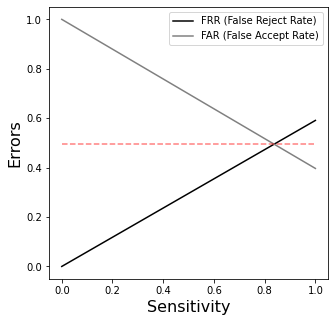

In [ ]:
metricas(y_true_train, y_pred_train)

Confusion matrix, without normalization


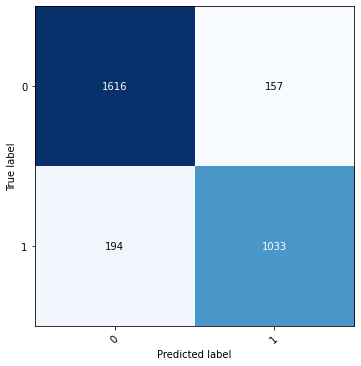

In [ ]:
cm = confusion_matrix(y_true_train, y_pred_train)
plot_confusion_matrix(cm, classes=np.arange(0,2), normalize=False)

### Métricas para os dados de validação

/usr/local/lib/python3.7/dist-packages/pyeer/eer_stats.py:219: UserWarning: It is possible that you had set the wrong score type. Please consider reviewing if you are using dissimilarity or similarity scores
  warn("It is possible that you had set the wrong score"


--------------------------------
Acurácia: 0.8860
Precision: 0.8877
Recall: 0.8218
F1: 0.8535
EER:  0.4850


Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated


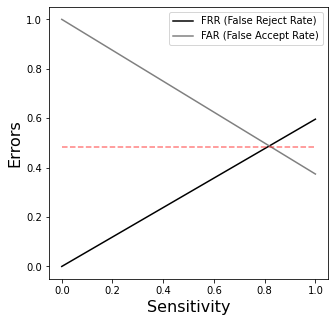

In [ ]:
metricas(y_true_val, y_pred_val)

Confusion matrix, without normalization


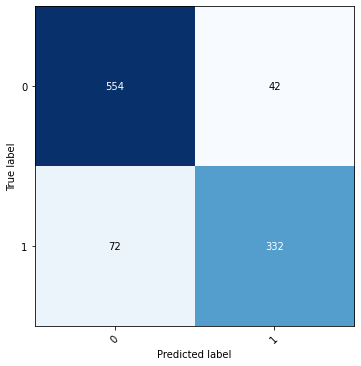

In [ ]:
cm = confusion_matrix(y_true_val, y_pred_val)
plot_confusion_matrix(cm, classes=np.arange(0,2), normalize=False)

### Métricas para os dados de teste

/usr/local/lib/python3.7/dist-packages/pyeer/eer_stats.py:219: UserWarning: It is possible that you had set the wrong score type. Please consider reviewing if you are using dissimilarity or similarity scores
  warn("It is possible that you had set the wrong score"


--------------------------------
Acurácia: 0.8700
Precision: 0.8679
Recall: 0.8326
F1: 0.8499
EER:  0.4910


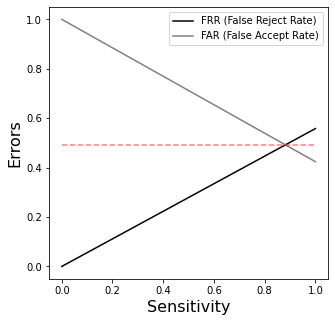

In [ ]:
metricas(y_true_test, y_pred_test)

Confusion matrix, without normalization


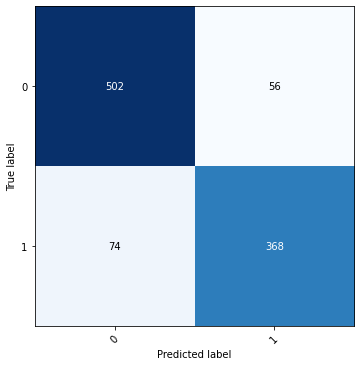

In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(cm, classes=np.arange(0,2), normalize=False)

## Salvando o modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
torch.save(modelo.state_dict(), '/content/drive/MyDrive/Doutorado/Disciplinas/[IA376-I] Introdução a Deep Learning/Exercício 7/modelo.pt')